In [47]:
# importing libraries
import pandas as pn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [48]:
# loading datasets
train= pd.read_csv("/content/drive/MyDrive/hack/sign_mnist_train.csv")
test= pd.read_csv("/content/drive/MyDrive/hack/sign_mnist_test.csv")

In [49]:
# checking no.of training and testing samples
train.shape,test.shape

((27455, 785), (7172, 785))

In [51]:
# calculating frequency of each character in our dataset
count= train['label'].value_counts()

<BarContainer object of 24 artists>

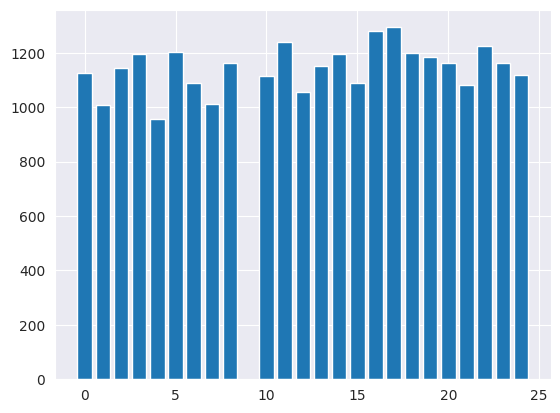

In [53]:
# plotting the frequency barplot
plt.figure() # Label Count
sbn.set_style("darkgrid")
plt.bar(count.index, count.values)

In [54]:
# splitting dataset
y_train =train['label']
y_test =test['label']
x_train=train.drop('label',axis=1)
x_test=test.drop('label',axis=1)

In [55]:
# Min-Max scaling the dataset
x_train = x_train / 255
x_test = x_test / 255

In [56]:
lb=LabelBinarizer()
y_train=lb.fit_transform(y_train)
y_test=lb.fit_transform(y_test)

In [57]:
# resizing the dataset
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

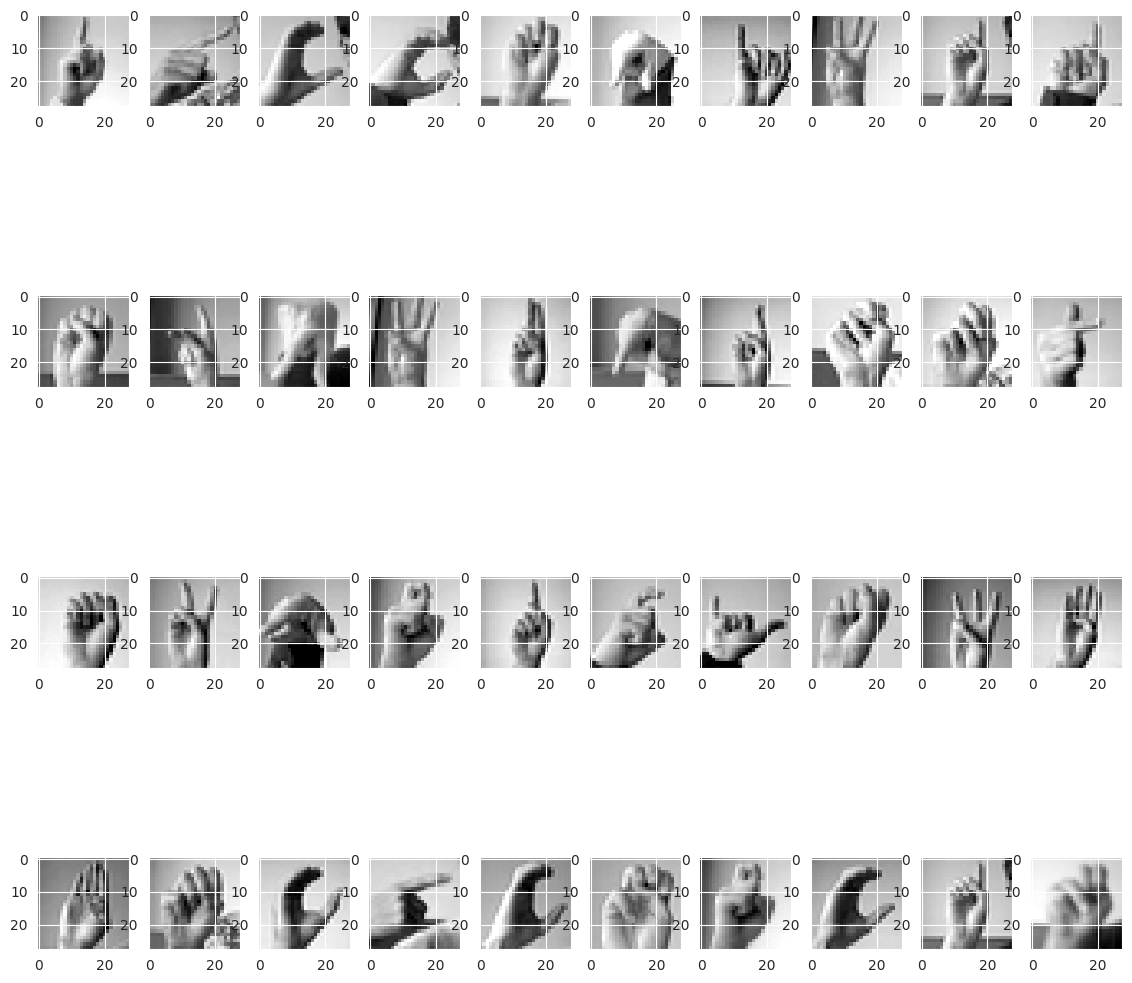

In [58]:
# displaying sample images from dataset
plt.figure(figsize=(14,14))
x, y = 10, 4
for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
plt.show()

###### Data augmentation is used to reduce overfitting when training a machine learning model, by training models on several slightly-modified copies of existing data. This is done by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.

In [59]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [60]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [61]:
# model architecture
model= Sequential()
model.add(Conv2D(35,
                 kernel_size=(3,3),   ## kernel size nedir
                 activation='relu',
                 input_shape=(28,28,1),
                 strides = 1 ,
                 padding = 'same'))

model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),
                    strides = 2 ,
                    padding = 'same'))
model.add(Conv2D(50,
                 kernel_size=(3,3),
                 strides=1,
                 padding='same',
                 activation='relu'))

model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2),
                    strides=2,
                    padding='same'))
model.add(Flatten())
model.add(Dense(units=24,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 35)        350       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 35)       140       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 35)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 50)        15800     
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 50)      

In [62]:
# training the model
history= model.fit(datagen.flow(x_train,y_train,batch_size=128),epochs=10, validation_data=(x_test,y_test), callbacks=[learning_rate_reduction])

Epoch 1/10
215/215 [==============================] - 82s 375ms/step - loss: 1.0834 - accuracy: 0.6713 - val_loss: 3.0107 - val_accuracy: 0.0524 - lr: 0.0010
Epoch 2/10
215/215 [==============================] - 61s 283ms/step - loss: 0.3323 - accuracy: 0.8935 - val_loss: 1.7255 - val_accuracy: 0.4179 - lr: 0.0010
Epoch 3/10
215/215 [==============================] - 63s 293ms/step - loss: 0.1792 - accuracy: 0.9442 - val_loss: 0.3001 - val_accuracy: 0.8915 - lr: 0.0010
Epoch 4/10
215/215 [==============================] - 58s 270ms/step - loss: 0.1153 - accuracy: 0.9631 - val_loss: 0.1294 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 5/10
215/215 [==============================] - 61s 284ms/step - loss: 0.0845 - accuracy: 0.9743 - val_loss: 0.0642 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 6/10
215/215 [==============================] - 60s 278ms/step - loss: 0.0660 - accuracy: 0.9784 - val_loss: 0.1073 - val_accuracy: 0.9759 - lr: 0.0010
Epoch 7/10
215/215 [==============================] 

In [63]:
# testing the model
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

225/225 [==============================] - 3s 13ms/step - loss: 0.0106 - accuracy: 0.9972
Accuracy of the model is -  99.72113966941833 %


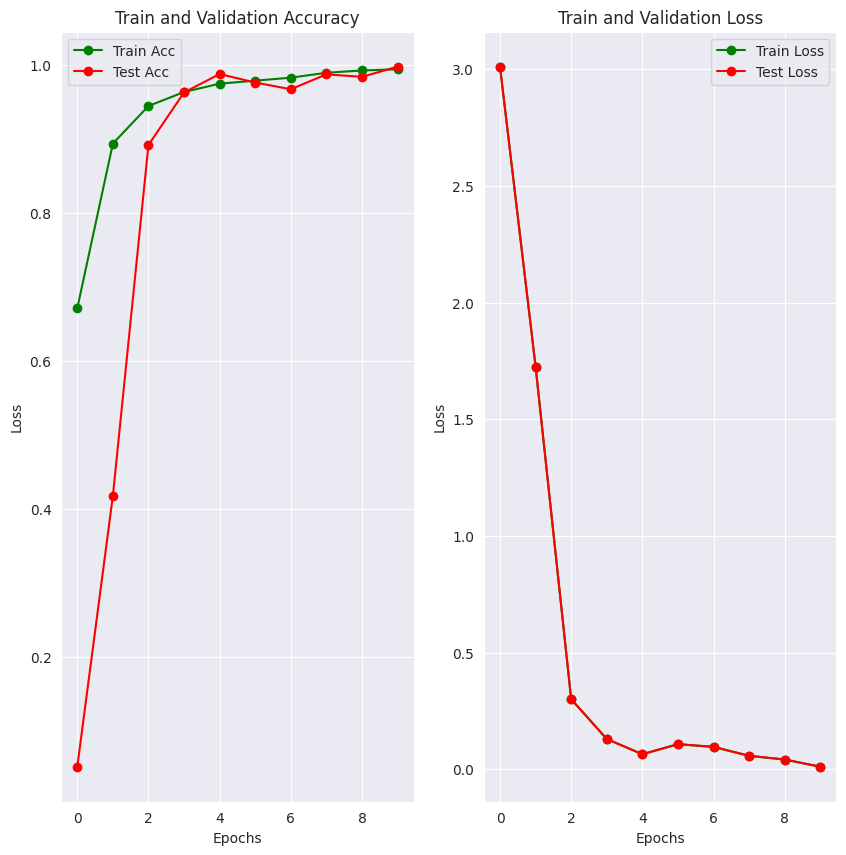

In [64]:
# plotting accuracy and loss curves
epochs = [i for i in range(10)]

fig,ax= plt.subplots(1,2)
train_acc= history.history['accuracy']
train_loss= history.history['loss']
vall_acc= history.history['val_accuracy']
vall_loss=history.history['val_loss']
fig.set_size_inches(10,10)

ax[0].plot(epochs, train_acc, 'go-', label='Train Acc')
ax[0].plot(epochs, vall_acc, 'ro-', label= 'Test Acc')
ax[0].set_title('Train and Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].plot(epochs, vall_loss, 'go-', label='Train Loss')
ax[1].plot(epochs, vall_loss, 'ro-', label= 'Test Loss')
ax[1].set_title('Train and Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [65]:
# generating predictions
predictions = model.predict(x_test)
predictions=np.argmax(predictions,axis=1)
predictions +=1

225/225 [==============================] - 3s 14ms/step


In [66]:
predictions.shape,x_test.shape

((7172,), (7172, 28, 28, 1))

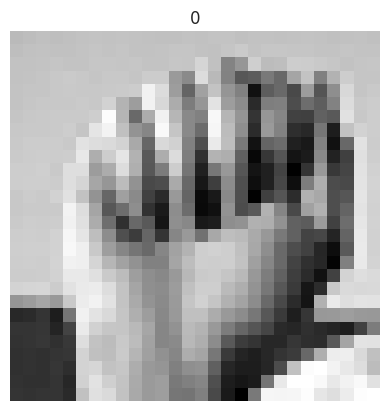

Predicted output:  A


In [75]:
# Prediction
plt.imshow(x_test[3].reshape(28,28),cmap='gray')
temp=np.where(y_test[3] == 1)[0][0]
plt.title(temp)
plt.axis('off')
plt.show()
print("Predicted output: ",chr(65+temp))

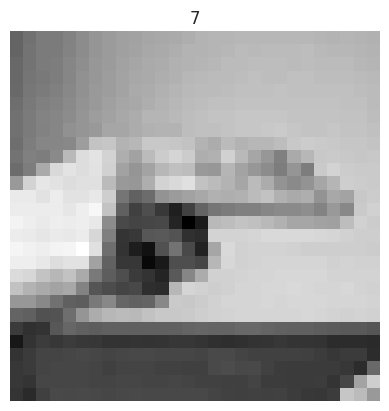

Predicted output:  H


In [76]:
# Prediction
plt.imshow(x_test[30].reshape(28,28),cmap='gray')
temp=np.where(y_test[30] == 1)[0][0]
plt.title(temp)
plt.axis('off')
plt.show()
print("Predicted output: ",chr(65+temp))

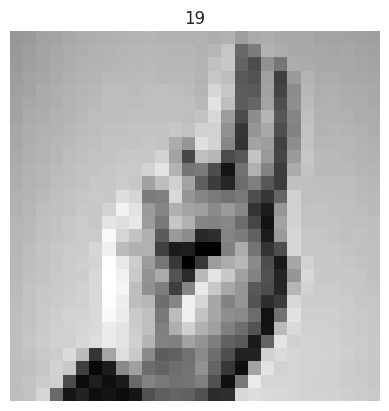

Predicted output:  T


In [77]:
# Prediction
plt.imshow(x_test[50].reshape(28,28),cmap='gray')
temp=np.where(y_test[50] == 1)[0][0]
plt.title(temp)
plt.axis('off')
plt.show()
print("Predicted output: ",chr(65+temp))

END


---

